In [1]:
import os
# import drjit
# gpu_num = [0, 1, 2, 3, 4] # Use "" to use the CPU
gpu_num = 1
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
print(tf.config.list_logical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))

[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU'), LogicalDevice(name='/device:GPU:4', device_type='GPU'), LogicalDevice(name='/device:GPU:5', device_type='GPU'), LogicalDevice(name='/device:GPU:6', device_type='GPU'), LogicalDevice(name='/device:GPU:7', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


(1, 1, 14, 10, 16, 16)


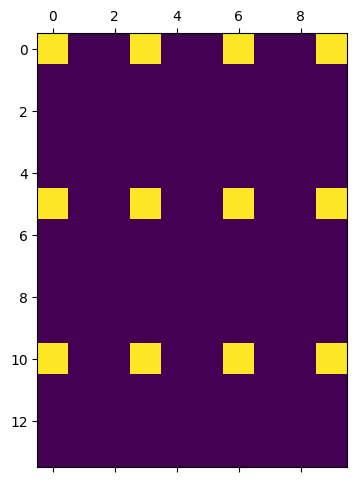

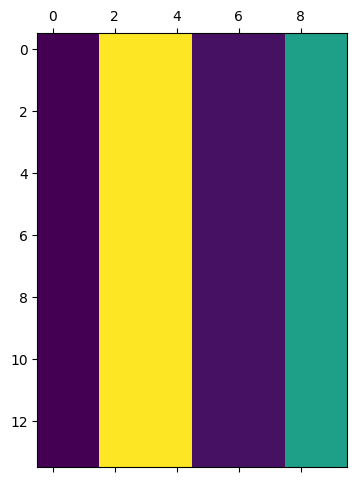

In [5]:
from jammer.interference import CovarianceEstimator
batch_size = 1
num_rx = 1
num_rx_ant = 16
num_ofdm_symbols = 14
fft_size = 10
num_silent_pilot_symbols = 4
model = Model(num_silent_pilot_symbols=num_silent_pilot_symbols, fft_size=fft_size, num_ofdm_symbols=num_ofdm_symbols, cyclic_prefix_length=0)

other_mask = np.zeros([1, 1, num_ofdm_symbols, fft_size])
other_mask[0, 0, ::5, ::3] = 1
plt.matshow(other_mask[0, 0])
other_pilots = np.zeros([1, 1, np.count_nonzero(other_mask)], dtype=np.complex64)
other_pilot_pattern = sionna.ofdm.PilotPattern(other_mask, other_pilots)
# cov = CovarianceEstimator(model._rg.pilot_pattern)
cov = CovarianceEstimator(other_pilot_pattern)
b = model._binary_source([batch_size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size*2])
x = model._mapper(b)
r = cov(x)

print(r.shape)
plt.matshow(np.abs(np.mean(r[0,0], axis=(-1,-2))))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7600e-02 | 5.2750e-01 |     1232061 |    32768000 |         3376 |        6400 |        33.5 |reached max iter       
   -2.778 | 1.1643e-02 | 1.9734e-01 |      381510 |    32768000 |         1263 |        6400 |        14.0 |reached max iter       
   -0.556 | 6.8445e-03 | 1.1188e-01 |      224281 |    32768000 |          716 |        6400 |        13.9 |reached max iter       
    1.667 | 5.1638e-03 | 8.3125e-02 |      169208 |    32768000 |          532 |        6400 |        13.7 |reached max iter       
    3.889 | 4.6047e-03 | 7.5313e-02 |      150887 |    32768000 |          482 |        6400 |        13.9 |reached max iter       
    6.111 | 4.4955e-03 | 7.3906e-02 |      147310 |    32768000 |          473 |     

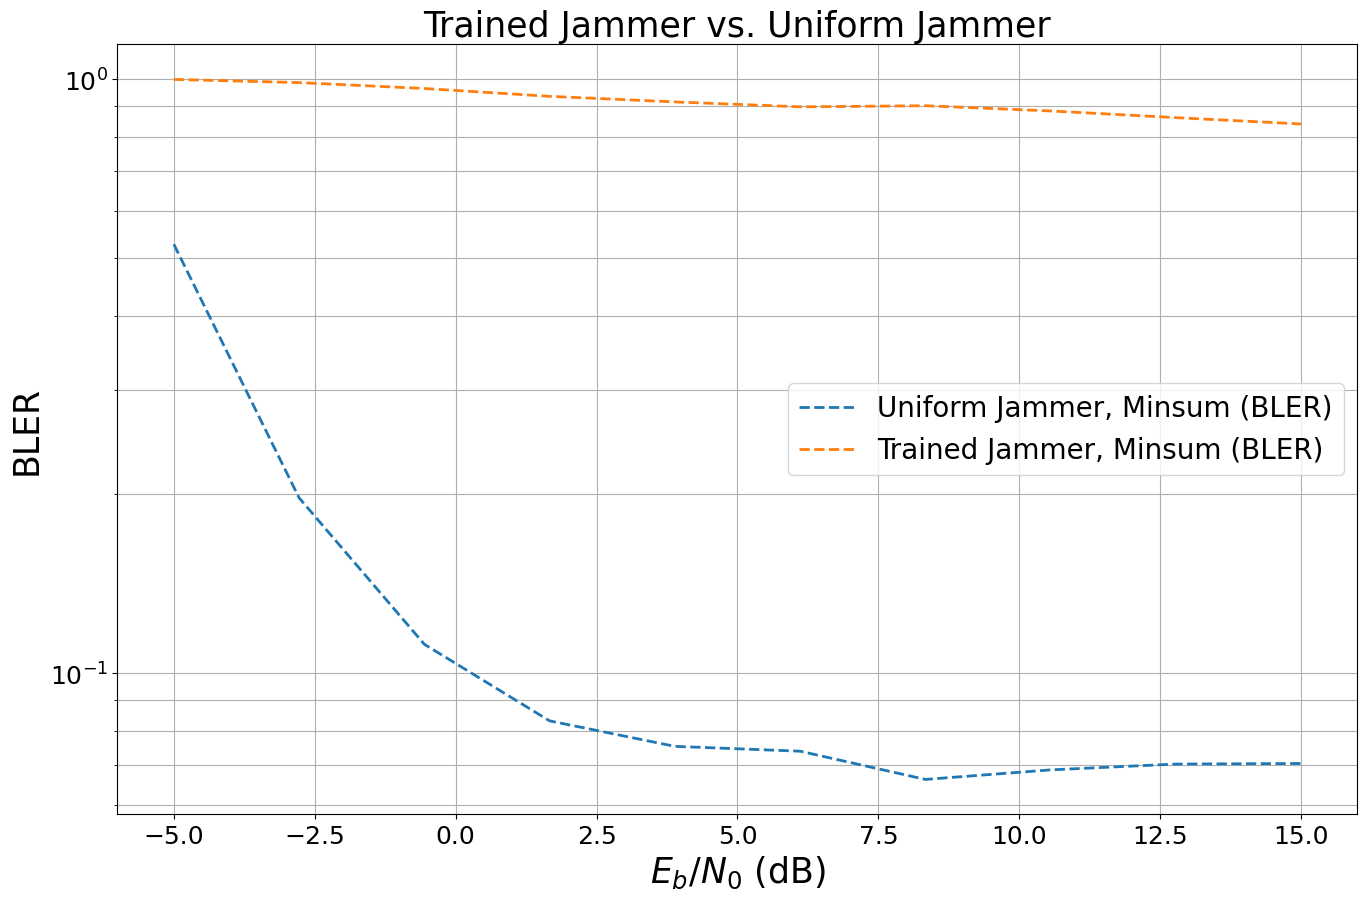

In [2]:
# noch einen Plot mit Minsum
ber_plots.reset()
# common parameters
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["num_ut"] = 4
model_parameters["jammer_present"] = True
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128], dtype=tf.bool)
decoder_parameters["num_iter"] = 20
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters
sim.BATCH_SIZE = 128
# sim.MAX_MC_ITER = 2000
# sim.ebno_dbs = np.linspace(-5., 15., 21)
# TODO change
sim.MAX_MC_ITER = 50
sim.ebno_dbs = np.linspace(-5., 15., 10)

# Uniform jammer with Minsum
decoder_parameters["cn_type"] = "minsum"
model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Uniform Jammer, Minsum", add_bler=True)

# Trained jammer
model = Model(**model_parameters)
model._decoder.llr_max = 1000
load_weights(model, f"weights/paper/ue_4_coded.pickle")
simulate_model(model, "Trained Jammer, Minsum", add_bler=True)

ber_plots.title = "Trained Jammer vs. Uniform Jammer"
ber_plots(show_ber=False)
# TODO save the plot
# with open("bers/paper/coded_bler.pickle", 'wb') as f:
#     bers = pickle.dump(ber_plots, f)